# **Predecir Ventas**

Instalaciones:
* pip install pandas
* pip install xlrd (para leer archivos de extension xls)
* pip install matplotlib
* pip install openpyxl
* pip install seaborn
* pip install scikit-learn

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# **1.  Carga de Datos**

**Dataframe dfData**
1. leemos la data de VENTAS KERA TEIN.xlsx
2. convertimos Fecha a datetime (ya viene bien)
3. ordenamos el dataframe por Fecha
4. calculamos LunesAnterior, para hacer agrupamientos por semana, encontrando cual es el lunes anterior para cada fila (Fecha)
5. calculamos FechaMes, para agrupar por mes
6. Dejamos en el dataframe solo Fecha, LunesAnterior, FechaMes y Cant. pedida



In [3]:
dfData = pd.read_excel('../Data Original/VENTAS KERA TEIN.xls')
#df = df[['Fecha','Fecha entrega','Cant. pedida', 'Cant. pendiente', 'Cant. comprom.', 'Cant. remision', 'Cant. factura']]
dfData = dfData[['Fecha','Cant. pedida']]
dfData = dfData.sort_values(by='Fecha')


# Función para obtener el lunes anterior a una fecha dada
def obtener_lunes_anterior(fecha):
    # Calcular el lunes anterior
    lunes_anterior = fecha - pd.DateOffset(days=fecha.weekday())
    return lunes_anterior

dfData['LunesAnterior'] = dfData['Fecha'].apply(obtener_lunes_anterior)

# Establecer la columna 'Fecha' como el índice del DataFrame
dfData['FechaMes'] = dfData['Fecha'].dt.to_period('M').dt.to_timestamp()

dfData = dfData[['Fecha','LunesAnterior','FechaMes','Cant. pedida']]

# **2. Agrupamientos**
Se logran agrupamientos por:
1. día:  Fecha --> sum('Cant. pedida')
2. semana:  LunesAnterior--> sum('Cant. pedida')
3. mes:  FechaMes --> sum('Cant. pedida')

In [15]:
df_dia = dfData.groupby('Fecha').agg({'Cant. pedida':'sum'}).reset_index()
df_semana = dfData.groupby('LunesAnterior').agg({'Cant. pedida':'sum'}).reset_index()
df_mes = dfData.groupby('FechaMes').agg({'Cant. pedida':'sum'}).reset_index()

df_mes.head()

,FechaMes,Cant. pedida
0,2017-09-01,120.0
1,2017-11-01,40.0
2,2017-12-01,80.0
3,2018-01-01,80.0
4,2018-02-01,120.0


# **3.  lectura del data adicional**

* **Dólar:  df_dolar**:  Trae el cambio del dólar por dia
* **Desempleo: df_desempleo**: Trae el cambio del IPC por mes

In [33]:
df_dolar = pd.read_csv('../Data Original/Datos históricos USD_COP.csv')

df_dolar['Fecha'] = pd.to_datetime(df_dolar['Fecha'], format='%d.%m.%Y')
df_dolar['Apertura']  = df_dolar['Apertura'].str.replace('.', '').str.replace(',', '.').astype(float)
df_dolar = df_dolar[['Fecha','Apertura']].copy()

df_dolar.rename(columns={'Apertura':'Dolar'}, inplace=True)
df_dolar=df_dolar.sort_values(by='Fecha', ascending=True).reset_index(drop=True)

df_dolar['FechaMes'] =  df_dolar['Fecha'].dt.to_period('M').dt.to_timestamp()
print('df_dolar:')
print(df_dolar.head())

df_desempleo = pd.read_excel('../Data Original/Desempleo.xlsx')
df_desempleo = df_desempleo[df_desempleo['Fecha']>='2016-01-01']
df_desempleo.columns = ['FechaMes','Desempleo']
df_desempleo.reset_index(inplace=True,drop=True)
print('')
print('df_desempleo:')
print(df_desempleo.head())

df_dolar:
       Fecha    Dolar   FechaMes
0 2016-01-01  3179.00 2016-01-01
1 2016-01-04  3175.65 2016-01-01
2 2016-01-05  3219.34 2016-01-01
3 2016-01-06  3212.00 2016-01-01
4 2016-01-07  3254.42 2016-01-01

df_desempleo:
    FechaMes  Desempleo
0 2016-01-31      12.18
1 2016-02-29      10.37
2 2016-03-31      10.46
3 2016-04-30       9.32
4 2016-05-31       9.24


# **3. Graficación**

Observamos con SeaBorn si la data tiene cierto comportamiento en el tiempo

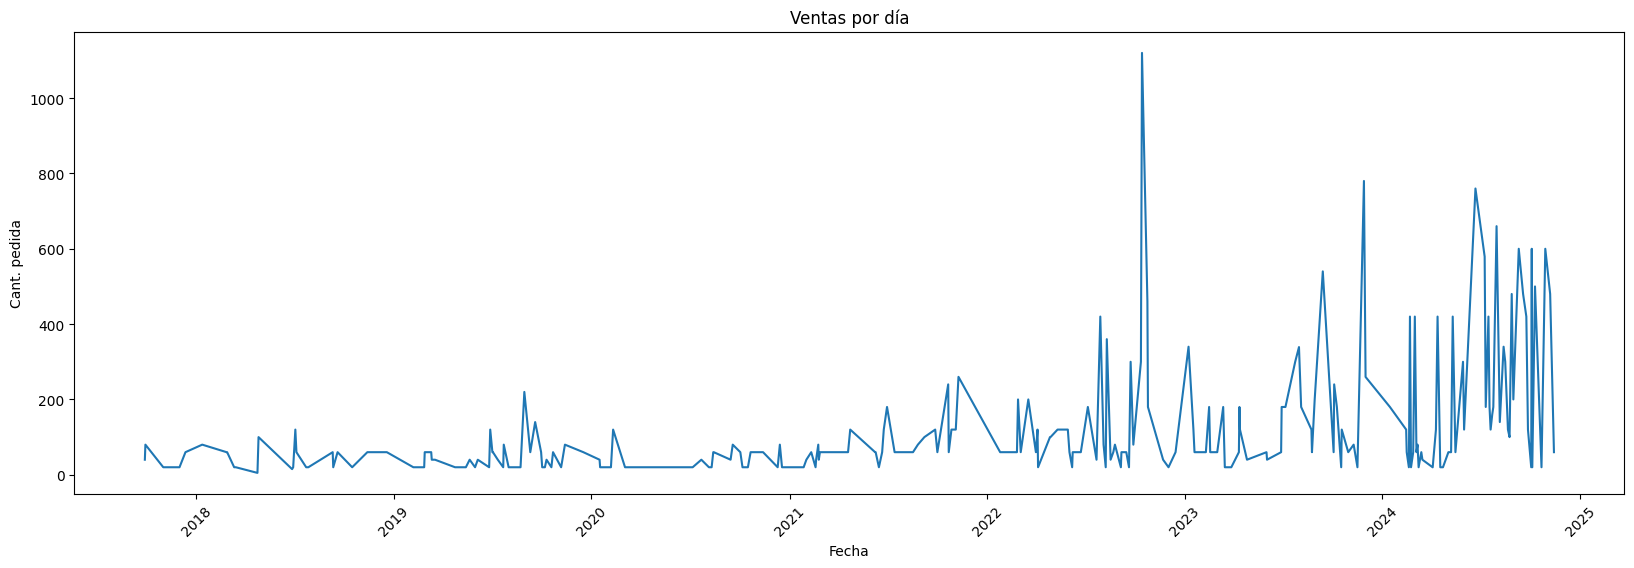

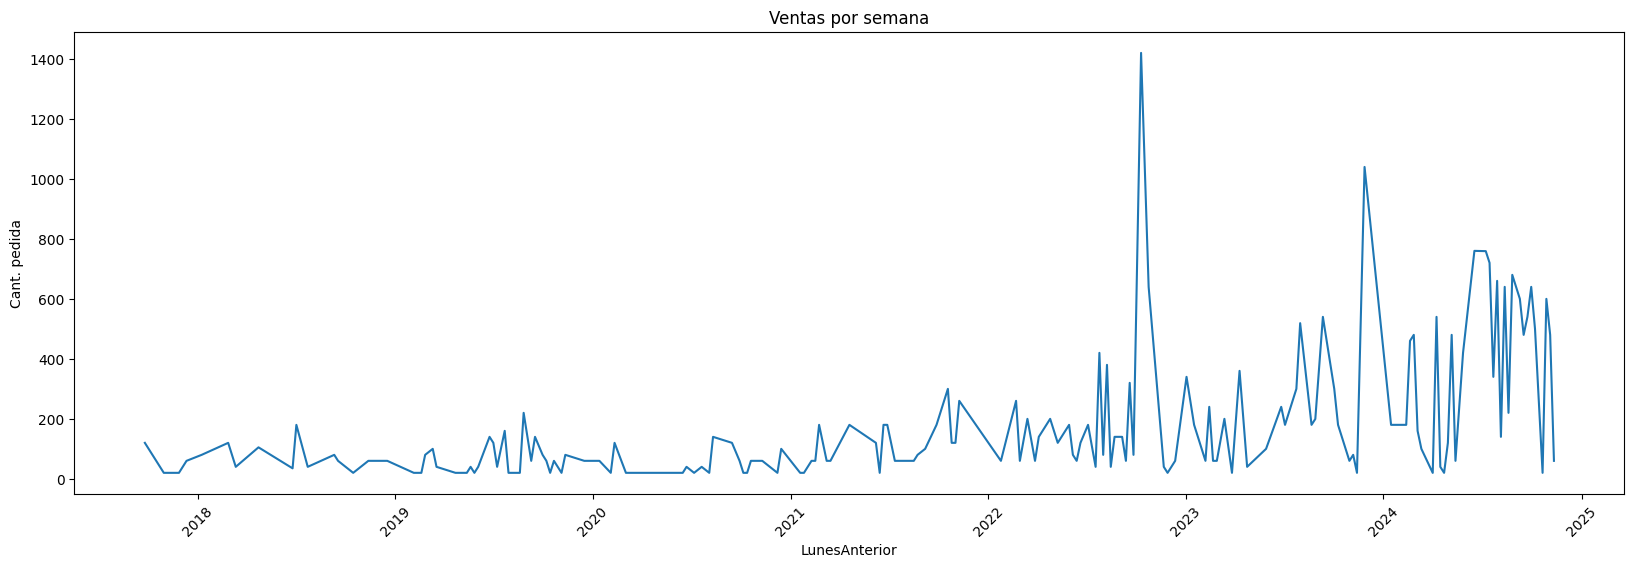

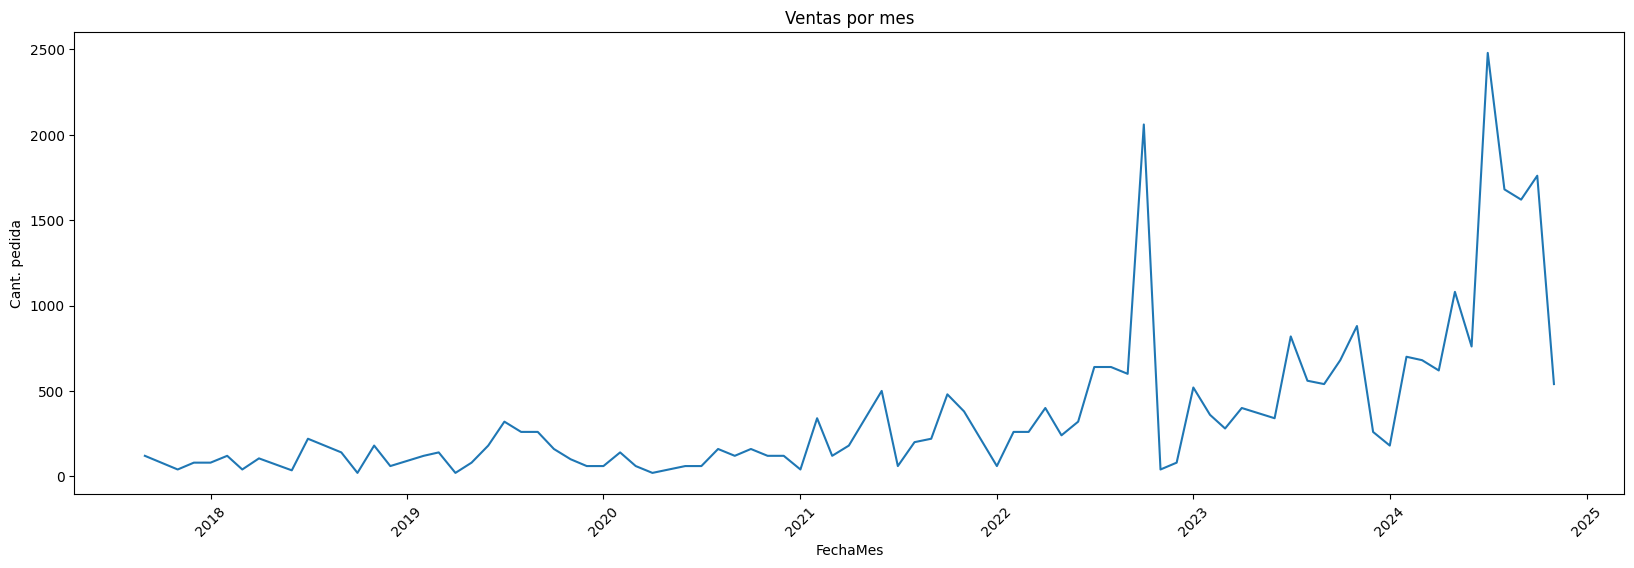

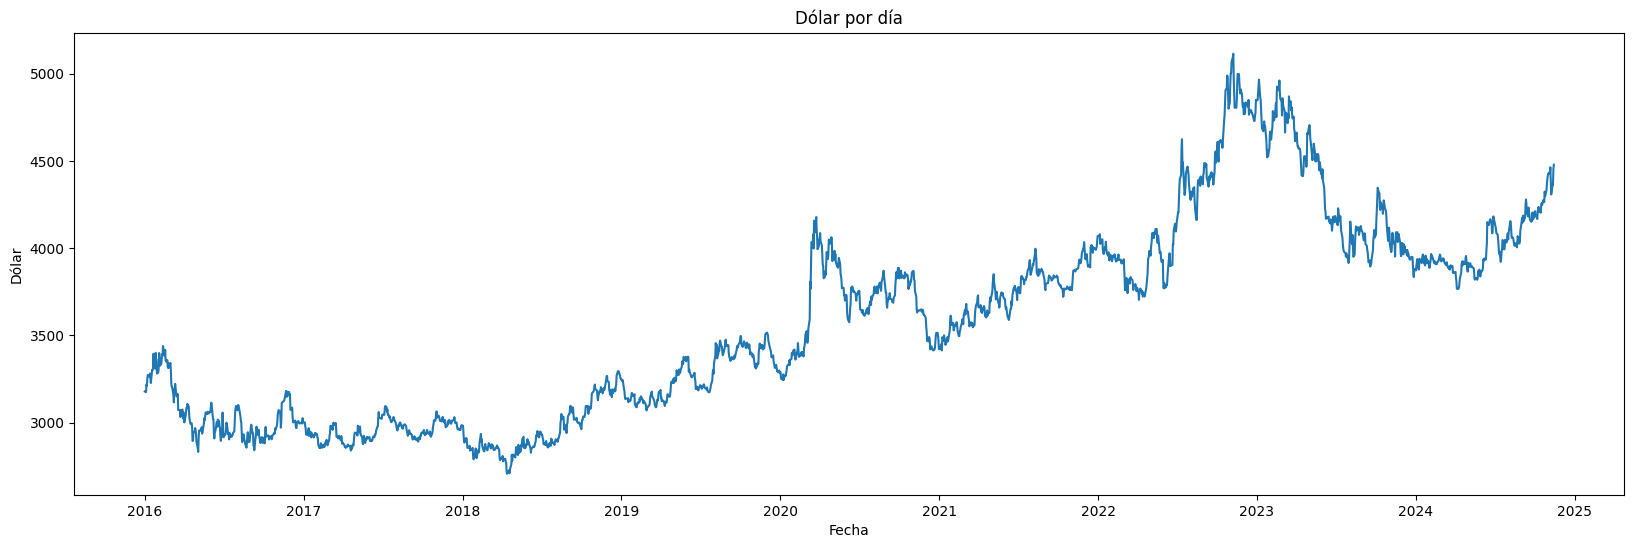

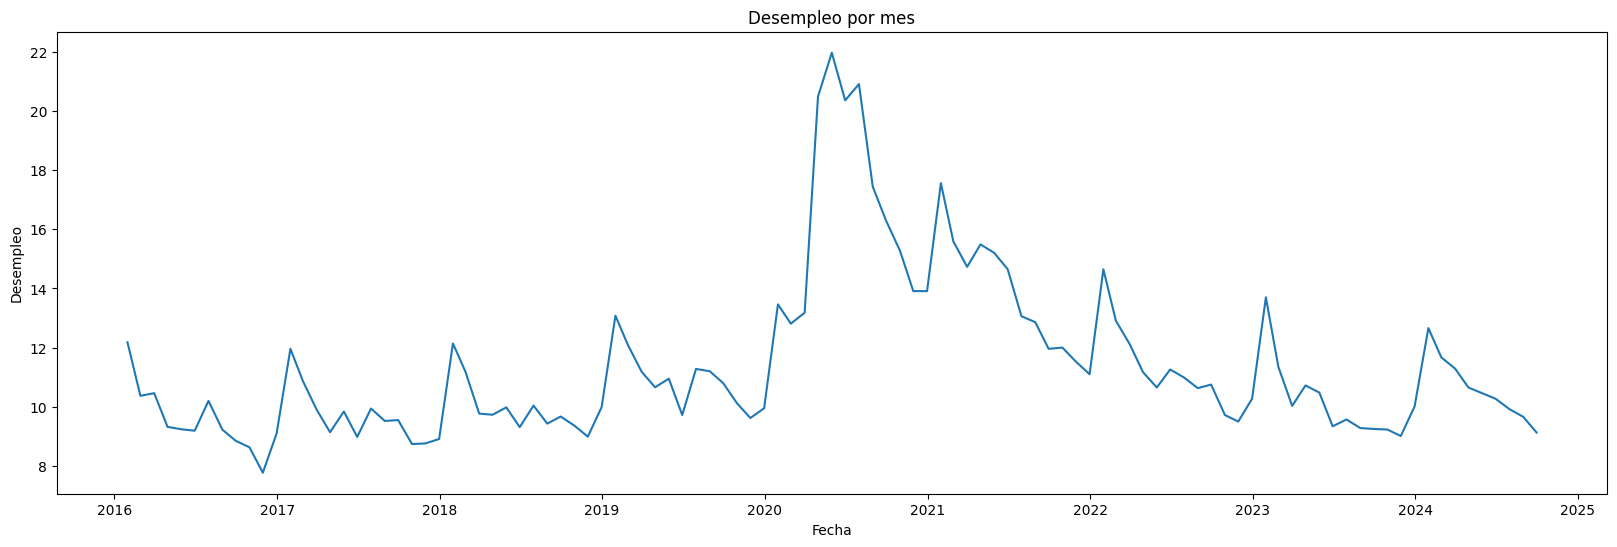

In [34]:
# VENTAS POR DIA
plt.figure(figsize=(20, 6))
sns.lineplot(x='Fecha', y='Cant. pedida', data=df_dia)
plt.xticks(rotation=45)
plt.title('Ventas por día')
plt.show()

# VENTAS POR SEMANA
plt.figure(figsize=(20, 6))
sns.lineplot(x='LunesAnterior', y='Cant. pedida', data=df_semana)
plt.xticks(rotation=45)
plt.title('Ventas por semana')
plt.show()

# VENTAS POR MES
plt.figure(figsize=(20, 6))
sns.lineplot(x='FechaMes', y='Cant. pedida', data=df_mes)
plt.xticks(rotation=45)
plt.title('Ventas por mes')
plt.show()

# VALOR DEL DOLAR 
plt.figure(figsize=(20, 6))
sns.lineplot(data=df_dolar, x='Fecha', y='Dolar')
plt.title('Dólar por día')
plt.xlabel('Fecha')
plt.ylabel('Dólar')
plt.show()

# DESEMPLEO POR MES
plt.figure(figsize=(20, 6))
sns.lineplot(data=df_desempleo, x='FechaMes', y='Desempleo')
plt.title('Desempleo por mes')
plt.xlabel('Fecha')
plt.ylabel('Desempleo')
plt.show()

# **4. Agrupamientos por MES**
Como primer intento, vamos a llevar todos los datos a mensual.  
* **df_mes**: ya está agrupado mensual los datos de ventas por mes
* **df_dolar_mes**:  agrupamiento del valor del dolar en el mes, obteniendo max, min y mean por cada mes
* **df_desempleo**: hay que ajustar la fecha para que en cada mes apunte al primer día de cada mes

In [44]:
print('\n Ventas por mes: df_mes')
print(df_mes.head())

# DOLAR POR MES
df_dolar_mes = df_dolar.groupby('FechaMes').agg({'Dolar':['max','min','mean']}).reset_index()
df_dolar_mes.columns = ['FechaMes','dolar_max','dolar_min','dolar_mean']
print('\n df_dolar_mes:')
print(df_dolar_mes.head())

# DESEMPLEO POR MES:   viene con fechas que cambian.   se colocan todos como el primer día del mes.
df_desempleo['FechaMes'] = (df_desempleo['FechaMes'] + pd.offsets.MonthBegin(1)).dt.to_period('M').dt.to_timestamp()
print('\n df_desempleo:')
print(df_desempleo.head())


 Ventas por mes: df_mes
    FechaMes  Cant. pedida
0 2017-09-01         120.0
1 2017-11-01          40.0
2 2017-12-01          80.0
3 2018-01-01          80.0
4 2018-02-01         120.0

 df_dolar_mes:
    FechaMes  dolar_max  dolar_min   dolar_mean
0 2016-01-01    3400.69    3175.65  3283.536190
1 2016-02-01    3439.38    3286.48  3358.501429
2 2016-03-01    3304.60    3025.28  3131.798696
3 2016-04-01    3108.00    2889.71  2998.006190
4 2016-05-01    3063.13    2833.00  2991.684091

 df_desempleo:
    FechaMes  Desempleo
0 2016-07-01      12.18
1 2016-08-01      10.37
2 2016-09-01      10.46
3 2016-10-01       9.32
4 2016-11-01       9.24


##  **Los dataframes de meses son:**
* df_mes : ventas por mes
* dfd_mes:  dolar max, min y mean por mes
* dfdes:  desempleo por mes

,FechaMes,Desempleo
0,2016-02-01,12.18
1,2016-03-01,10.37
2,2016-04-01,10.46
3,2016-05-01,9.32
4,2016-06-01,9.24
...,...,...
99,2024-05-01,10.65
100,2024-07-01,10.27
101,2024-08-01,9.92
102,2024-09-01,9.66


In [13]:
dfTotal = pd.merge(df_mes, dfd_mes, on='FechaMes', how='inner')
dfTotal = pd.merge(dfTotal, dfdes, on='FechaMes', how='inner')
dfTotal

,FechaMes,Cant. pedida,dolar_max,dolar_min,dolar_mean,Desempleo
0,2017-09-01,120.0,2946.25,2892.15,2918.210476,9.52
1,2017-11-01,40.0,3065.00,2974.00,3014.794091,8.74
2,2017-12-01,80.0,3031.85,2958.50,2991.371905,8.76
3,2018-01-01,80.0,2984.50,2790.30,2872.967391,8.91
4,2018-02-01,120.0,2936.00,2796.80,2857.659000,12.14
...,...,...,...,...,...,...
72,2024-05-01,1080.0,3917.00,3819.95,3867.410435,10.65
73,2024-07-01,2479.1,4148.63,3922.17,4038.896957,10.27
74,2024-08-01,1680.0,4155.62,4005.22,4063.025909,9.92
75,2024-09-01,1620.0,4279.60,4147.26,4190.302381,9.66


* extraer otras caracteristicas

In [18]:
dfTotal['Mes'] = dfTotal['FechaMes'].dt.month
dfTotal['Trimestre'] = dfTotal['FechaMes'].dt.quarter

In [19]:
dfTotal

,FechaMes,Cant. pedida,dolar_max,dolar_min,dolar_mean,Desempleo,Mes,Trimestre
0,2017-09-01,120.0,2946.25,2892.15,2918.210476,9.52,9,3
1,2017-11-01,40.0,3065.00,2974.00,3014.794091,8.74,11,4
2,2017-12-01,80.0,3031.85,2958.50,2991.371905,8.76,12,4
3,2018-01-01,80.0,2984.50,2790.30,2872.967391,8.91,1,1
4,2018-02-01,120.0,2936.00,2796.80,2857.659000,12.14,2,1
...,...,...,...,...,...,...,...,...
72,2024-05-01,1080.0,3917.00,3819.95,3867.410435,10.65,5,2
73,2024-07-01,2479.1,4148.63,3922.17,4038.896957,10.27,7,3
74,2024-08-01,1680.0,4155.62,4005.22,4063.025909,9.92,8,3
75,2024-09-01,1620.0,4279.60,4147.26,4190.302381,9.66,9,3


*  Vamos a normalizar los datos en dfN

In [29]:
from sklearn.preprocessing import MinMaxScaler

# quitamos la FechaMes
dfTemp = dfTotal.drop('FechaMes', axis=1)

# escalamos
minMax = MinMaxScaler()
dfN = minMax.fit_transform(dfTemp)
dfN.shape

(77, 7)

* la columna a predecir es 'Cant. pedida'